In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime

from scipy.stats import shapiro
from scipy.stats import kruskal

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from feature_engine.outliers import Winsorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [39]:
SEEEDDDD = 88

In [2]:
df_raw = pd.read_csv('2A.tsv', sep='\t')
df_raw.head()

,Customer ID,Birth Date,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,1969/03/05,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,2005/07/01,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,1974/12/01,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,2003/11/21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,1979/09/13,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Birth Date                3900 non-null   object 
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

- The dataset doesn't contain any null values
- Birth Date column should be converted to datetime type instead of object to handle date operations properly

In [4]:
# Remove 'Customer ID' columns as they are not necessary for analysis
df_raw.drop('Customer ID', axis=1, inplace=True)

In [5]:
# Remove duplicate data
print(df_raw.duplicated().sum())
df_raw = df_raw.drop_duplicates().reset_index(drop=True)

0


There are no duplicate rows

In [6]:
# Correcting data types
df_raw['Birth Date'] = pd.to_datetime(df_raw['Birth Date'], errors='coerce')
# Derive Age 
df_raw['Age'] = datetime.now().year - df_raw['Birth Date'].dt.year

In [7]:
df_raw.describe()

,Birth Date,Purchase Amount (USD),Review Rating,Previous Purchases,Age
count,3900,3900.000000,3900.000000,3900.000000,3900.000000
mean,1980-06-07 01:19:23.076923072,59.764359,3.749949,25.351538,45.068462
min,1954-01-01 00:00:00,20.000000,2.500000,1.000000,19.000000
25%,1967-04-16 18:00:00,39.000000,3.100000,13.000000,32.000000
50%,1980-06-09 00:00:00,60.000000,3.700000,25.000000,45.000000
75%,1993-08-22 12:00:00,81.000000,4.400000,38.000000,58.000000
max,2006-12-29 00:00:00,100.000000,5.000000,50.000000,71.000000
std,NaN,23.685392,0.716223,14.447125,15.207589


1. Purchase Amount (USD): The purchase amount ranges from 20 to 100 USD, with most purchases falling between 39 and 81 USD, showing a slightly skewed but reasonable distribution without extreme outliers.
   
2. Review Rating: Review ratings range from 2.5 to 5, with most ratings clustered around the higher end, indicating consistently positive reviews with no significant outliers.

3. Previous Purchases: The number of previous purchases ranges from 1 to 50, with a relatively uniform distribution, showing reasonable variation but no extreme outliers.

4. Age: Age ranges from 19 to 71 years, with a balanced distribution around a median of 45, covering a broad range of age groups without significant outliers.

In [8]:
df_raw.describe(include='object')

,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,4,25,4,50,4,25,4,2,6,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Credit Card,Free Shipping,No,No,PayPal,Every 3 Months
freq,2642,171,1737,96,1755,177,999,2847,696,675,2223,2223,677,584


- Gender is dominated by Male with over 2600 occurrences, while Subscription Status is mostly No.
- Item Purchased and Category have more diversity, with Clothing being the most common item and category.
- Size distribution favors M, and Color distribution is fairly even, with Olive being the most frequent.
- Payment Methods and Shipping Types show some variety, but Credit Card and Free Shipping are the most frequent.

In [9]:
# Input: df - A pandas DataFrame to analyze for missing values
# Process: The function calculates the number of missing values and their percentage in each column of the DataFrame
# Output: Prints a table showing the column names, number of missing values, and percentage of missing values for each column

def check_na_count (df):
    # Calculate the number of missing values in each column
    missing_values = df.isna().sum()
    # Calculate the percentage of missing values in each column
    missing_percentage = (missing_values / df.shape[0]) * 100

    # Print column headers
    print(f"{'Column':<25}{'Missing Values':<20}{'Percentage':<15}")
    print("="*65)

    # Iterate through each column and print the missing values and their percentage
    for column in df.columns:
        print(f"{column:<25}{missing_values[column]:<20}{missing_percentage[column]:<5.2f}%")

# Call the function on the df_raw DataFrame
check_na_count(df_raw)

Column                   Missing Values      Percentage     
Birth Date               0                   0.00 %
Gender                   0                   0.00 %
Item Purchased           0                   0.00 %
Category                 0                   0.00 %
Purchase Amount (USD)    0                   0.00 %
Location                 0                   0.00 %
Size                     0                   0.00 %
Color                    0                   0.00 %
Season                   0                   0.00 %
Review Rating            0                   0.00 %
Subscription Status      0                   0.00 %
Payment Method           0                   0.00 %
Shipping Type            0                   0.00 %
Discount Applied         0                   0.00 %
Promo Code Used          0                   0.00 %
Previous Purchases       0                   0.00 %
Preferred Payment Method 0                   0.00 %
Frequency of Purchases   0                   0.00 %
Age

In [10]:
# Numerical columns
num_cols = ['Purchase Amount (USD)', 'Review Rating', 'Previous Purchases' ,'Age']

# Categorical columns
cat_cols = [
    'Gender', 'Item Purchased', 'Category', 'Location', 
    'Size', 'Color', 'Season', 'Subscription Status', 'Payment Method', 'Shipping Type', 
    'Discount Applied', 'Promo Code Used', 'Preferred Payment Method', 'Frequency of Purchases'
]

In [11]:
# Drop the 'Birth Date' column and create a copy of the DataFrame
df_new = df_raw.drop(columns=['Birth Date']).copy()

In [12]:
# Univariate Analysis (mode)
for i in cat_cols:
    print(df_new[i].value_counts(),'\n')

Gender
Male      2642
Female    1231
f           17
M           10
Name: count, dtype: int64 

Item Purchased
Blouse        171
Jewelry       171
Pants         171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Belt          161
Sunglasses    161
Coat          161
Sandals       160
Socks         159
Skirt         158
Shorts        157
Scarf         157
Hat           154
Handbag       153
Hoodie        151
Shoes         150
T-shirt       147
Sneakers      145
Boots         144
Backpack      143
Gloves        140
Jeans         124
Name: count, dtype: int64 

Category
Clothing       1737
Accessories    1240
Footwear        599
Outerwear       324
Name: count, dtype: int64 

Location
Montana           96
California        95
Idaho             93
Illinois          92
Alabama           89
Minnesota         88
Nebraska          87
New York          87
Nevada            87
Maryland          86
Delaware          86
Vermont           85
Louisiana         84
North Dakota 

From the result, we can see in the column 'Frequency of Purchases' that 'Fortnightly' and 'Bi-Weekly' are equivalent, and 'Every 3 Months' and 'Quarterly' are also the same. Similarly, in the 'Gender' column, 'f' is equal to 'Female' and 'M' is equal to 'Male'.

In [13]:
# Define mappings for Gender to handle inconsistencies ('f' and 'M' to full words)
gender_mapping = {'f': 'Female', 'M': 'Male'}
df_new['Gender'] = df_new['Gender'].replace(gender_mapping)  # Replace the gender values based on the mapping

# Define mappings for Frequency of Purchases to handle inconsistencies ('Fortnightly' to 'Bi-Weekly' and 'Every 3 Months' to 'Quarterly')
frequency_mapping = {
    'Fortnightly': 'Bi-Weekly',  # Replace 'Fortnightly' with 'Bi-Weekly'
    'Every 3 Months': 'Quarterly'  # Replace 'Every 3 Months' with 'Quarterly'
}
df_new['Frequency of Purchases'] = df_new['Frequency of Purchases'].replace(frequency_mapping)  # Apply mapping

Purchase Amount (USD)


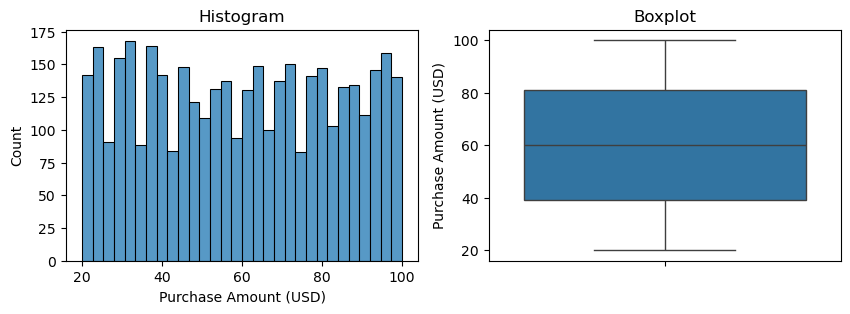

Skewness: 0.012701757626433795
Kurtosis: -1.236593691266159
Review Rating


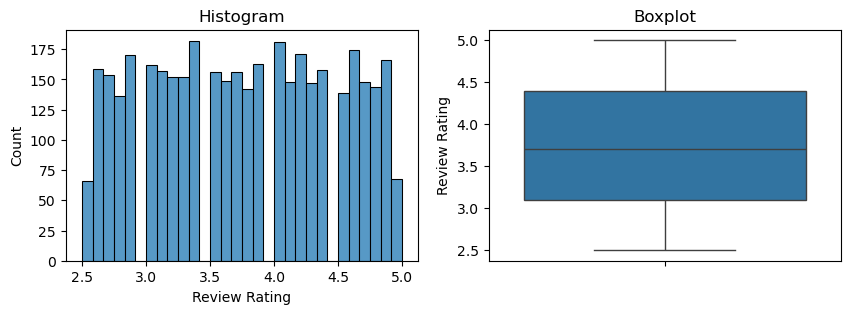

Skewness: 0.00452459644246527
Kurtosis: -1.1796283021299137
Previous Purchases


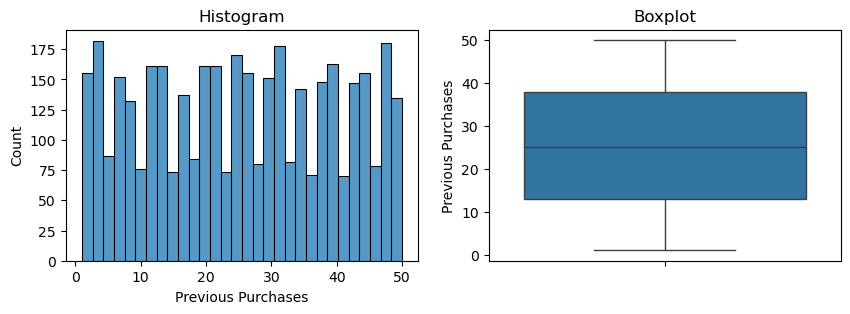

Skewness: 0.0031211555127652127
Kurtosis: -1.1901873846405375
Age


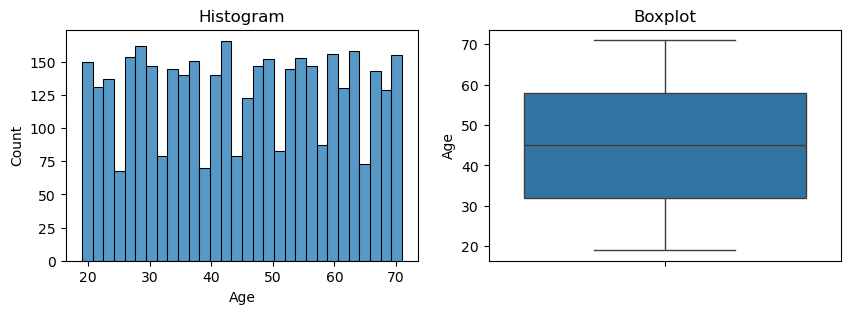

Skewness: -0.0063797217209905395
Kurtosis: -1.1950871489241808


In [14]:
# Input: a pandas DataFrame containing the dataset, columns - A list of numerical columns to analyze
# Process: generates histograms and boxplots for each specified numerical column and calculates the skewness and kurtosis for those columns
# Output: displays histograms and boxplots for each numerical column and prints the skewness and kurtosis values for each

def check_distribution_outliers(df, columns):
    for col in columns:
        print(col)
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title('Boxplot')

        plt.show()

        # Calculate and print skewness and kurtosis
        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df_raw, num_cols)

1. Purchase Amount (USD): The distribution is fairly uniform between 20 and 100 USD with no significant outliers
2. Review Rating: Most ratings fall between 3 and 4, with a slight skew towards higher ratings
3. Previous Purchases: Purchases are spread evenly between 1 and 50, with no major peaks
4. Age: Age is evenly distributed between 19 and 71, with a slight concentration in the younger range

In [16]:
# Calculate the correlation matrix for numerical columns
correlation_data = df_new[num_cols].corr()
correlation_data

,Purchase Amount (USD),Review Rating,Previous Purchases,Age
Purchase Amount (USD),1.000000,0.030776,0.008063,-0.010424
Review Rating,0.030776,1.000000,0.004229,-0.021949
Previous Purchases,0.008063,0.004229,1.000000,0.040445
Age,-0.010424,-0.021949,0.040445,1.000000


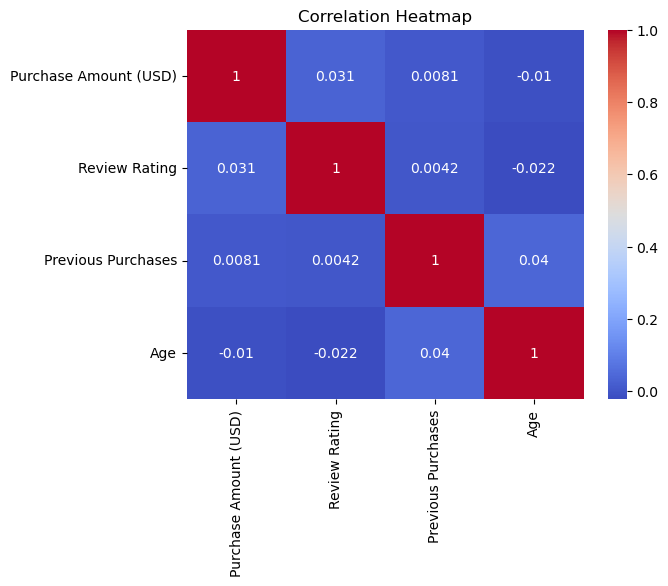

In [17]:
# Plot a heatmap of the correlation matrix using seaborn
sns.heatmap(correlation_data, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- The variables in this dataset show weak correlations with each other. The highest correlation is between Purchase Amount and Review Rating (0.030776), but it is still very weak.
- There is no significant linear relationship between the numerical variables, as all correlations are close to zero.

### Preprocessing

##### Handling Outliers

In [18]:
# Input: a pandas DataFrame containing numerical data, where 'num_cols' specifies the columns to analyze for outliers
# Process: calculates the 1st (1%) and 99th (99%) percentiles for each numerical column in 'num_cols', identifies outliers as values outside these percentiles, and stores the count of outliers for each column in a dictionary
# Output: returns a dictionary containing the number of outliers for each numerical column

def count_outliers(df):
    outlier_counts = {}  # Initialize an empty dictionary to store outlier counts
    for col in num_cols:  # Loop through each numerical column
        # Calculate the 1st (1%) and 99th (99%) percentiles for outlier detection
        lower_bound = df[col].quantile(0.01)
        upper_bound = df[col].quantile(0.99)
        
        # Find the rows that are outside the bounds (outliers)
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        # Store the number of outliers in the dictionary
        outlier_counts[col] = len(outliers)

    return outlier_counts

# Call the function on df_new (or your DataFrame)
outliers = count_outliers(df_new)
print(outliers)

{'Purchase Amount (USD)': 36, 'Review Rating': 0, 'Previous Purchases': 0, 'Age': 0}


In [19]:
# Initialize the Winsorizer to cap extreme values using the 1st and 99th percentiles for all numerical columns
winsorizer = Winsorizer(
    capping_method='quantiles',  # Use quantiles (percentiles) for capping
    tail='both',  # Apply capping to both tails (below the 1st percentile and above the 99th percentile)
    fold=0.01,  # Set the fold to 1% and 99% (this defines the 1st and 99th percentiles as capping points)
    variables=num_cols,  # Apply the transformation to the columns listed in num_cols
    missing_values='ignore'  # Ignore missing values (no effect on NaNs)
)

df_cleaned = df_new.copy()

# Apply the Winsorizer transformation to the numerical columns (num_cols) and store the result in df_cleaned
df_cleaned[num_cols] = winsorizer.fit_transform(df_cleaned[num_cols])


In [20]:
count_outliers(df_cleaned)

{'Purchase Amount (USD)': 0,
 'Review Rating': 0,
 'Previous Purchases': 0,
 'Age': 0}

We have no more outlier in our dataframe

##### Encoding

In [21]:
df= df_cleaned.copy()
df

,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases,Age
0,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Bi-Weekly,56
1,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Bi-Weekly,20
2,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly,51
3,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly,22
4,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,Cash,2-Day Shipping,No,No,32,Venmo,Weekly,41
3896,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,PayPal,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly,53
3897,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Credit Card,Standard,No,No,24,Venmo,Quarterly,47
3898,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,PayPal,Express,No,No,24,Venmo,Weekly,45


In [22]:
df['Size'].unique()

array(['L', 'S', 'M', 'XL'], dtype=object)

We can map these values to an ordinal scale since the sizes have a natural order

In [23]:
# Define the columns to encode
binary_cols = ['Gender', 'Subscription Status', 'Discount Applied', 'Promo Code Used']
ordinal_cols = ['Size', 'Frequency of Purchases']
nominal_cols = ['Item Purchased', 'Category', 'Location', 'Color', 'Season', 'Payment Method', 'Shipping Type', 'Preferred Payment Method']

In [24]:
lab_enc = LabelEncoder()
# Loop through each column in binary_cols and apply the encoding
for col in binary_cols:
    # Apply Label Encoding to the binary column and replace the original column with encoded values
    df[col] = lab_enc.fit_transform(df[col])

In [25]:
# Encode ordinal columns (Size)
size_map = {'S': 0, 'M': 1, 'L': 2, 'XL': 3}
df['Size'] = df['Size'].map(size_map).astype(int)
df['Size'].unique()

array([2, 0, 1, 3])

In [26]:
# Encode ordinal columns (Frequency of Purchases) from least to most frequent

frequency_map = {
    'Annually': 0,
    'Quarterly': 1,
    'Monthly': 2,
    'Bi-Weekly': 3,
    'Weekly': 4
}
df['Frequency of Purchases'] = df['Frequency of Purchases'].map(frequency_map)

In [27]:
# Input: a pandas DataFrame, and features - a list of columns in the DataFrame for which frequency encoding is applied.
# Process: calculates the normalized frequency of each category in the specified columns by dividing the count of each category by the total number of rows.
# Output: a pandas Series containing the normalized frequency of each category in the specified columns.

def features_encode(data, features):
    # Calculate frequency per category and normalize by the total number of rows
    freq_encoding = data.groupby(features).size() / len(data)
    return freq_encoding

In [28]:
df_enc = df.copy()

# Columns for Frequency Encoding
freq_encoding_cols = ['Location', 'Item Purchased', 'Color']

# Frequency Encoding for selected columns
for col in freq_encoding_cols:
    freq_map = features_encode(df_enc, col)  # Get the frequency encoding for the column
    df_enc[col] = df_enc[col].map(freq_map)  # Replace categories with their normalized frequency

In [29]:
# One-Hot Encoding for the remaining categorical columns
onehot_cols = [col for col in nominal_cols if col not in freq_encoding_cols]
print(onehot_cols)

# Apply One-Hot Encoding
df_enc2 = pd.get_dummies(df_enc, columns=onehot_cols, drop_first=True)
df_enc2

['Category', 'Season', 'Payment Method', 'Shipping Type', 'Preferred Payment Method']


,Gender,Item Purchased,Purchase Amount (USD),Location,Size,Color,Review Rating,Subscription Status,Discount Applied,Promo Code Used,...,Shipping Type_Express,Shipping Type_Free Shipping,Shipping Type_Next Day Air,Shipping Type_Standard,Shipping Type_Store Pickup,Preferred Payment Method_Cash,Preferred Payment Method_Credit Card,Preferred Payment Method_Debit Card,Preferred Payment Method_PayPal,Preferred Payment Method_Venmo
0,1,0.043846,53,0.020256,2,0.040769,3.1,1,1,1,...,True,False,False,False,False,False,False,False,False,True
1,1,0.042051,64,0.019744,2,0.040513,3.1,1,1,1,...,True,False,False,False,False,True,False,False,False,False
2,1,0.031795,73,0.018462,0,0.040513,3.1,1,1,1,...,False,True,False,False,False,False,True,False,False,False
3,1,0.041026,90,0.016154,1,0.040513,3.5,1,1,1,...,False,False,True,False,False,False,False,False,True,False
4,1,0.043846,49,0.018974,1,0.037179,2.7,1,1,1,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,0,0.038718,28,0.019744,2,0.037179,4.2,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3896,0,0.036667,49,0.017692,2,0.036410,4.5,0,0,0,...,False,False,False,False,True,False,False,False,False,False
3897,0,0.041282,33,0.017179,2,0.043333,2.9,0,0,0,...,False,False,False,True,False,False,False,False,False,True
3898,0,0.038462,77,0.022564,0,0.036154,3.8,0,0,0,...,True,False,False,False,False,False,False,False,False,True


##### Scaling

Since there are no outliers in this data, MinMaxScaler will effectively normalize the features

In [33]:
min_max_scaler = MinMaxScaler()
df_encoded = df_enc2.copy()

# Apply the MinMaxScaler to the numerical columns in the DataFrame
df_encoded[num_cols] = min_max_scaler.fit_transform(df_encoded[num_cols])

In [34]:
df_encoded

,Gender,Item Purchased,Purchase Amount (USD),Location,Size,Color,Review Rating,Subscription Status,Discount Applied,Promo Code Used,...,Shipping Type_Express,Shipping Type_Free Shipping,Shipping Type_Next Day Air,Shipping Type_Standard,Shipping Type_Store Pickup,Preferred Payment Method_Cash,Preferred Payment Method_Credit Card,Preferred Payment Method_Debit Card,Preferred Payment Method_PayPal,Preferred Payment Method_Venmo
0,1,0.043846,0.417722,0.020256,2,0.040769,0.24,1,1,1,...,True,False,False,False,False,False,False,False,False,True
1,1,0.042051,0.556962,0.019744,2,0.040513,0.24,1,1,1,...,True,False,False,False,False,True,False,False,False,False
2,1,0.031795,0.670886,0.018462,0,0.040513,0.24,1,1,1,...,False,True,False,False,False,False,True,False,False,False
3,1,0.041026,0.886076,0.016154,1,0.040513,0.40,1,1,1,...,False,False,True,False,False,False,False,False,True,False
4,1,0.043846,0.367089,0.018974,1,0.037179,0.08,1,1,1,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,0,0.038718,0.101266,0.019744,2,0.037179,0.68,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3896,0,0.036667,0.367089,0.017692,2,0.036410,0.80,0,0,0,...,False,False,False,False,True,False,False,False,False,False
3897,0,0.041282,0.164557,0.017179,2,0.043333,0.16,0,0,0,...,False,False,False,True,False,False,False,False,False,True
3898,0,0.038462,0.721519,0.022564,0,0.036154,0.52,0,0,0,...,True,False,False,False,False,False,False,False,False,True


### Dimensionality Reduction

In [35]:
# Initialize PCA (Principal Component Analysis)
pca = PCA()
# Fit the PCA model to the scaled data (df_encoded) to learn the principal components
pca.fit(df_encoded)

PCA()

Text(0, 0.5, 'Eigenvalues')

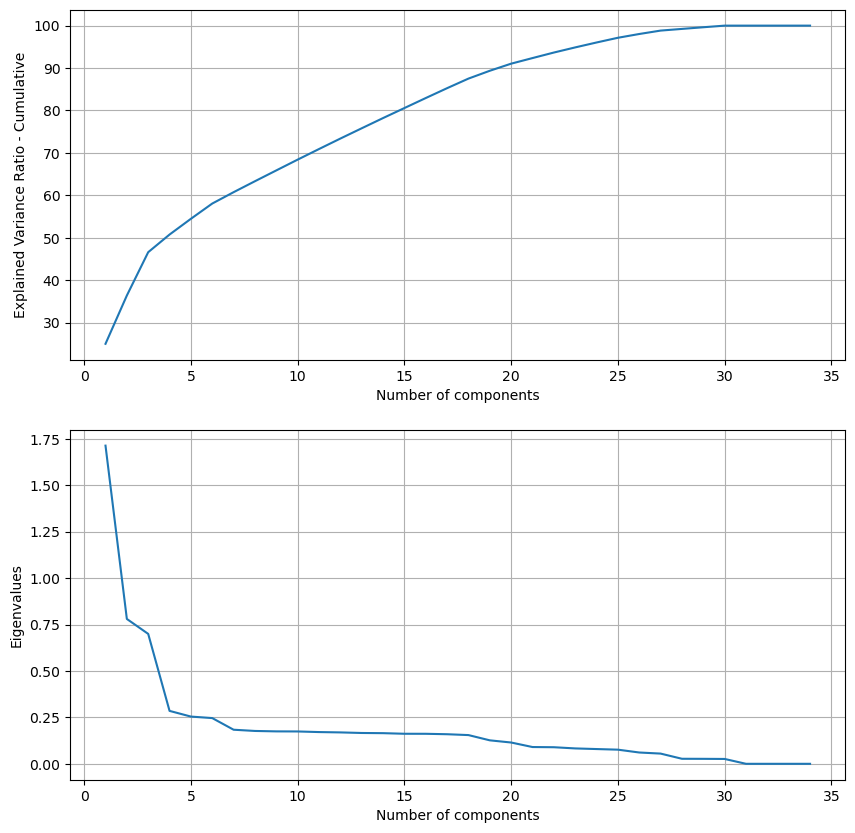

In [36]:
plt.figure(figsize=(10, 10))

# First subplot: Cumulative explained variance ratio
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(range(1, len(df_encoded.columns)+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cumulative')

# Second subplot: Eigenvalues
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(range(1, len(df_encoded.columns)+1), pca.explained_variance_)
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

Text(0, 0.5, 'Eigenvalues')

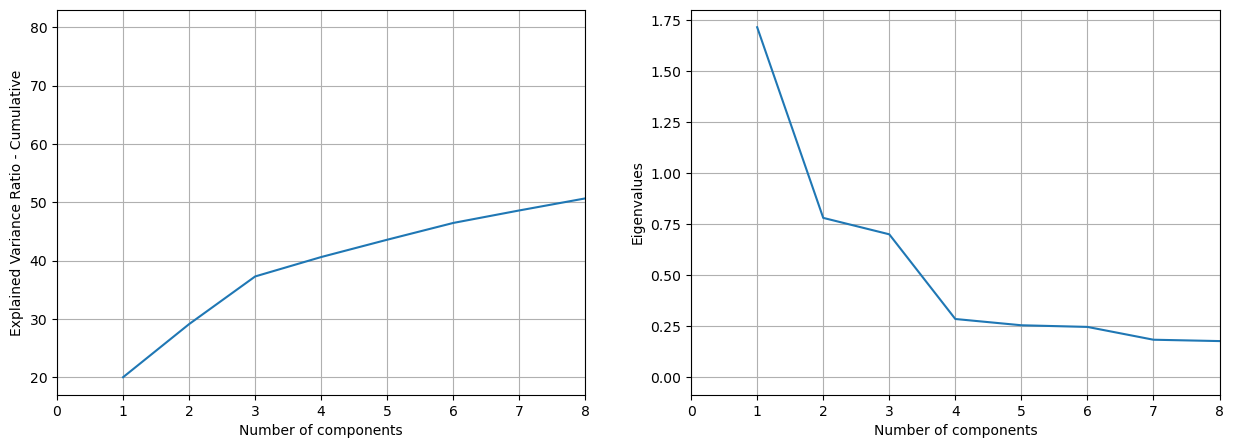

In [37]:
# First subplot: Cumulative explained variance ratio, zoomed in on x-axis from 0 to 8
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, len(df_encoded.columns)+1), np.cumsum(pca.explained_variance_ratio_ * 80))
plt.xlim(0, 8)  # Zoom in the x-axis from 0 to 8
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cumulative')

# Second subplot: Eigenvalues, zoomed in on x-axis from 0 to 8
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, len(df_encoded.columns)+1), pca.explained_variance_)
plt.xlim(0, 8)  # Zoom in the x-axis from 0 to 8
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

Explained Variance Ratio (Cumulative):

This plot shows the cumulative percentage of variance explained by the principal components. As the number of components increases, the cumulative variance approaches 100%, indicating that all of the original variance is explained by the components. From the graph, it’s clear that a small number of components (possibly the first 3 to 4) capture the majority of the variance. After the initial steep increase, the curve levels off, indicating that additional components contribute very little to the explanation of the variance in the data. This suggests that dimensionality reduction can be applied effectively by selecting only a few components.

Eigenvalues:

The eigenvalue plot shows how much variance is explained by each individual principal component. Higher eigenvalues correspond to more important components. The plot shows a sharp decline after the first few components, where the first component explains the most variance, followed by a significant drop. The remaining components have very small eigenvalues, indicating they don’t contribute much to explaining the variance.

So, I decided to use only 3 components based on the explained variance ratio and eigenvalues plot

In [38]:
# Using PCA to reduce the data to 3 components
pca_comp = PCA(n_components=3)
df_pca = pca_comp.fit_transform(df_encoded)

### B. Modelling and Fine Tuning

Metrics
- Silhouette Score is used to evaluate how well-defined the clusters are by measuring the separation between clusters
- WCSS (Within-Cluster Sum of Squares or Inertia) is used to measure the compactness of the clusters (i.e., the sum of squared distances of samples to their closest cluster center)

In [ ]:
# Fine-tuning KMeans model using Silhouette Score and WCSS

# Initialize lists to store distortion and silhouette scores for each k
distortions = []
silhouettes = []

# Set the range of cluster values (from 2 to 9)
K = range(2, 10)

# Loop over different numbers of clusters
for k in K:
    # Create the KMeans model with k clusters
    kmeanModel = KMeans(n_clusters=k, random_state=SEEEDDDD)
    
    # Fit the KMeans model on the data and predict the cluster labels
    cluster_label = kmeanModel.fit_predict(df_pca)
    
    # Calculate the silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(df_pca, cluster_label)
    
    # Print the silhouette score and WCSS (inertia) for the current k
    print(f"For n_clusters = {k}:")
    print(f"  The average silhouette_score is: {silhouette_avg}")
    print(f"  The WCSS (inertia) is: {kmeanModel.inertia_}")
    
    # Append the inertia (distortion) and silhouette score to the respective lists
    distortions.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_avg)


For n_clusters = 2:
  The average silhouette_score is: 0.37390410026512644
  The WCSS (inertia) is: 7257.796056056957
For n_clusters = 3:
  The average silhouette_score is: 0.2779262936686564
  The WCSS (inertia) is: 6360.405097962809
For n_clusters = 4:
  The average silhouette_score is: 0.30574021667360984
  The WCSS (inertia) is: 5222.623387957152
For n_clusters = 5:
  The average silhouette_score is: 0.3383591715601525
  The WCSS (inertia) is: 4151.029656093229
For n_clusters = 6:
  The average silhouette_score is: 0.3454416988101923
  The WCSS (inertia) is: 3525.883591892504
For n_clusters = 7:
  The average silhouette_score is: 0.3729285041542415
  The WCSS (inertia) is: 3008.3038267270977
For n_clusters = 8:
  The average silhouette_score is: 0.4001792593443527
  The WCSS (inertia) is: 2461.503752705035
For n_clusters = 9:
  The average silhouette_score is: 0.42052526935762014
  The WCSS (inertia) is: 2185.5515568295923


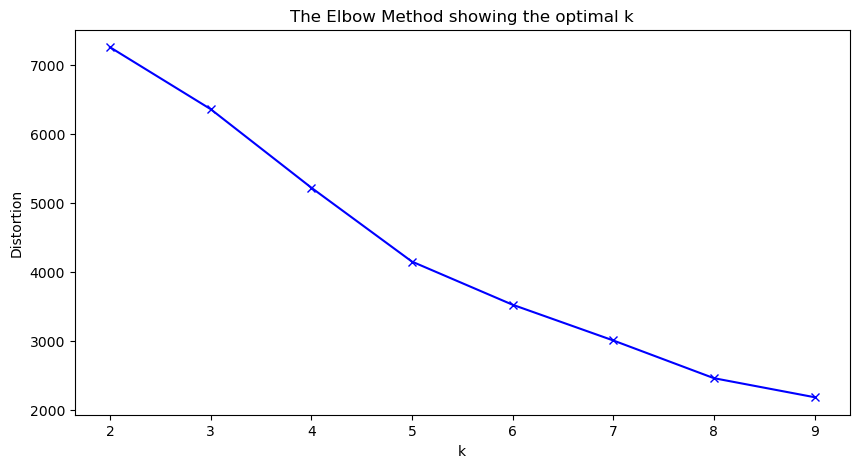

In [41]:
# Plot the Elbow Method to determine the optimal number of clusters (k) for KMeans clustering
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The Elbow is the point where the rate of decrease in distortion starts to slow down significantly. In this case, the elbow seems to occur around k = 3, as the distortion reduction becomes less steep after this point. Based on this observation, k = 3 might be the optimal number of clusters, as it provides a good balance between a low distortion value and a reasonable number of clusters.

For n_clusters = 2, The average silhouette_score is: 0.37390410026512644
For n_clusters = 3, The average silhouette_score is: 0.2779262936686564
For n_clusters = 4, The average silhouette_score is: 0.30574021667360984
For n_clusters = 5, The average silhouette_score is: 0.3383591715601525
For n_clusters = 6, The average silhouette_score is: 0.3454416988101923
For n_clusters = 7, The average silhouette_score is: 0.3729285041542415
For n_clusters = 8, The average silhouette_score is: 0.4001792593443527
For n_clusters = 9, The average silhouette_score is: 0.42052526935762014


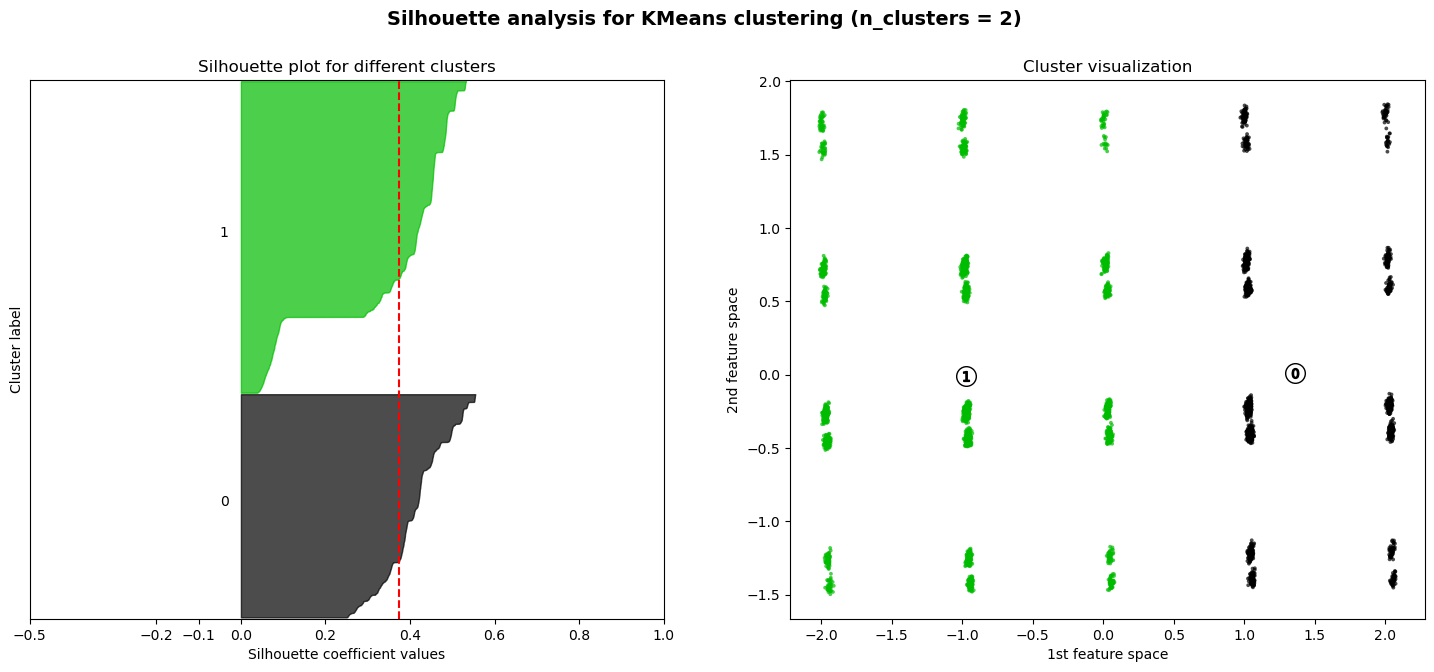

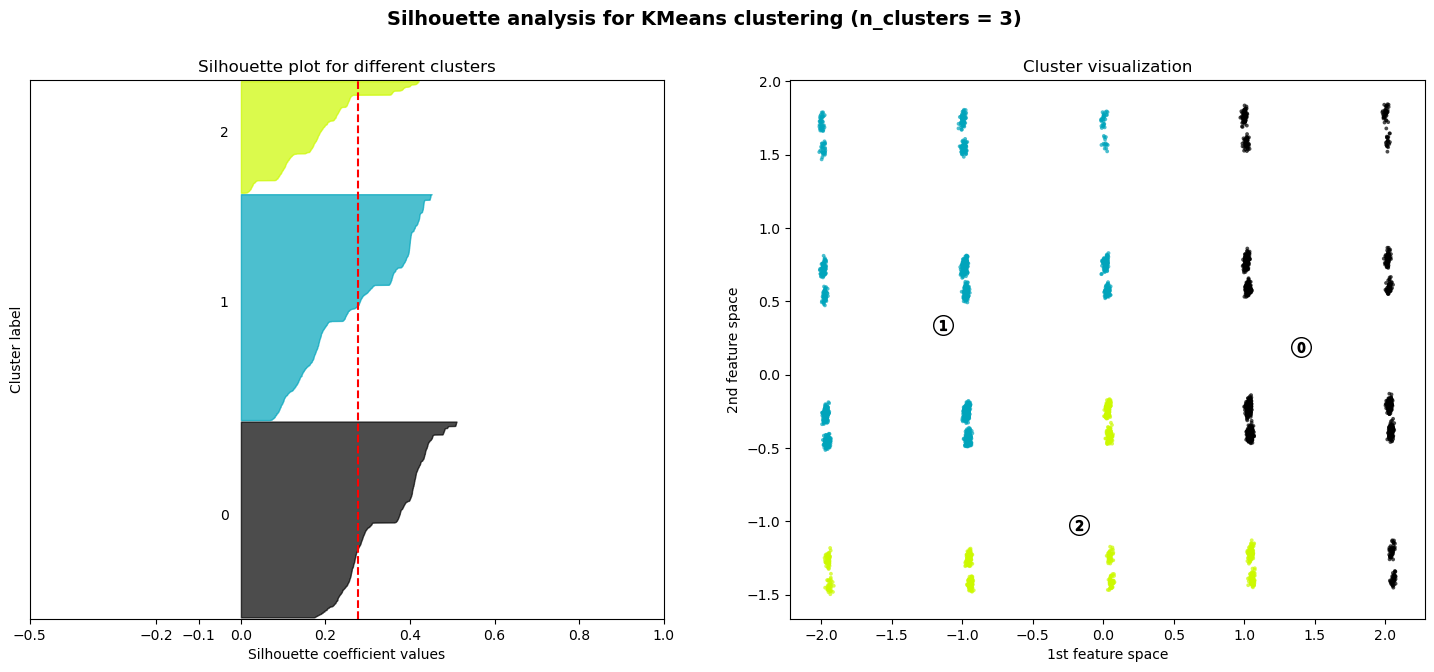

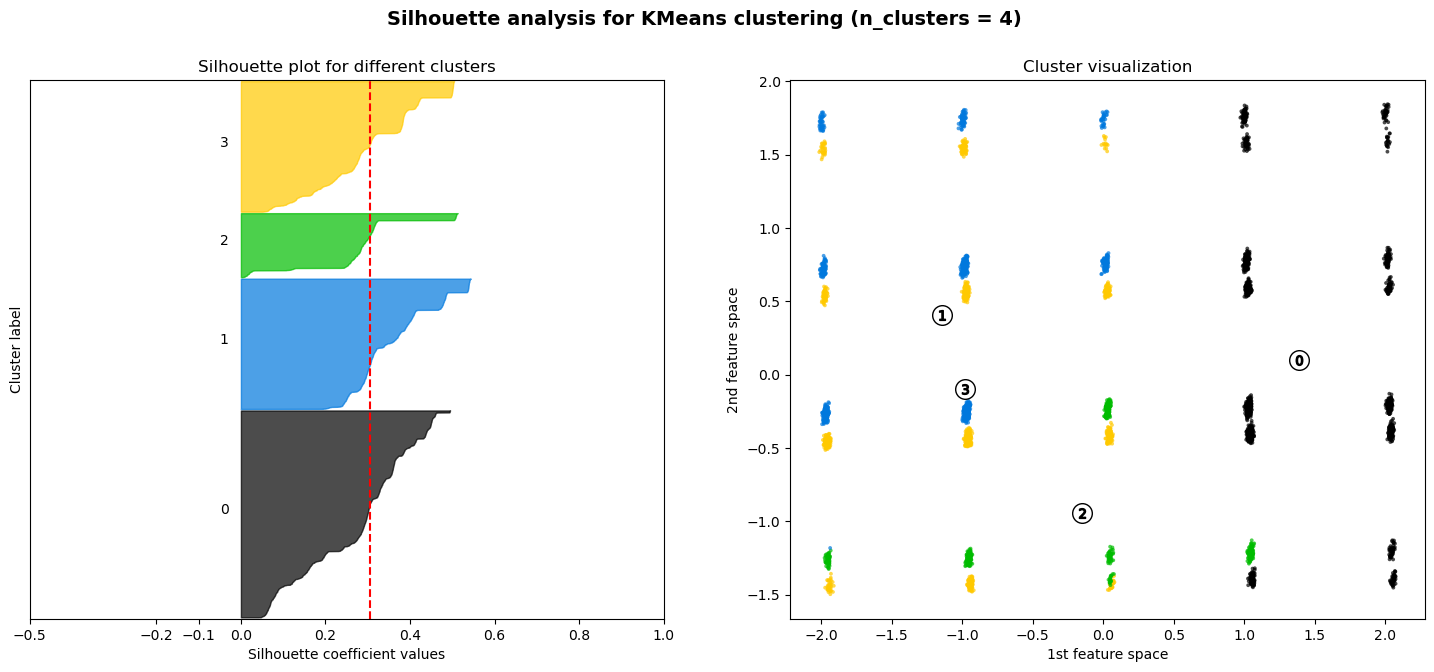

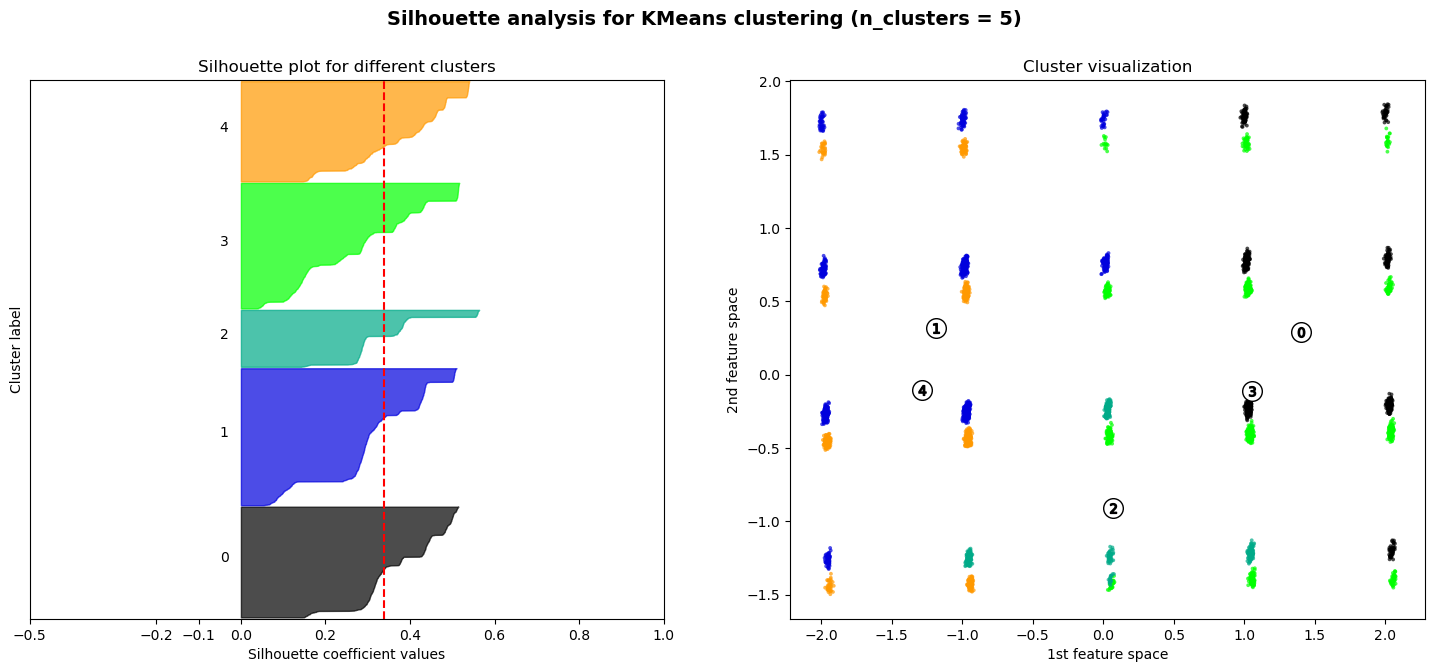

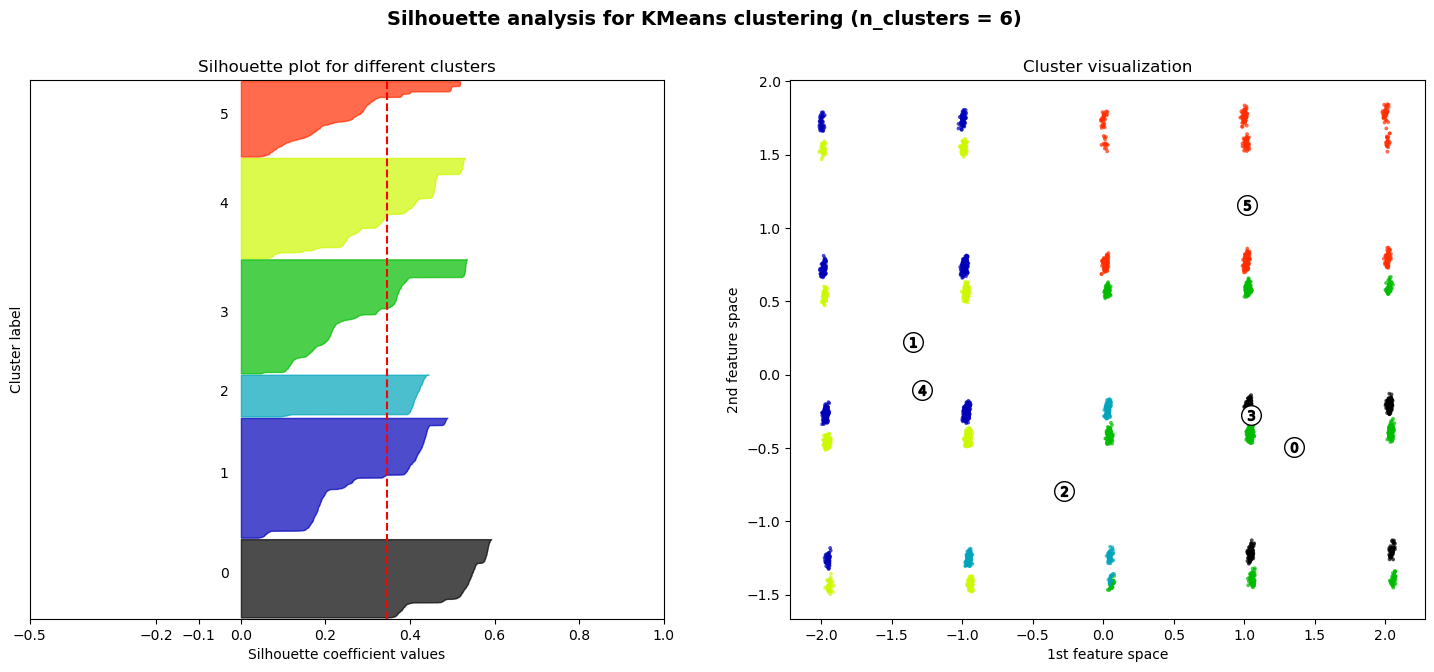

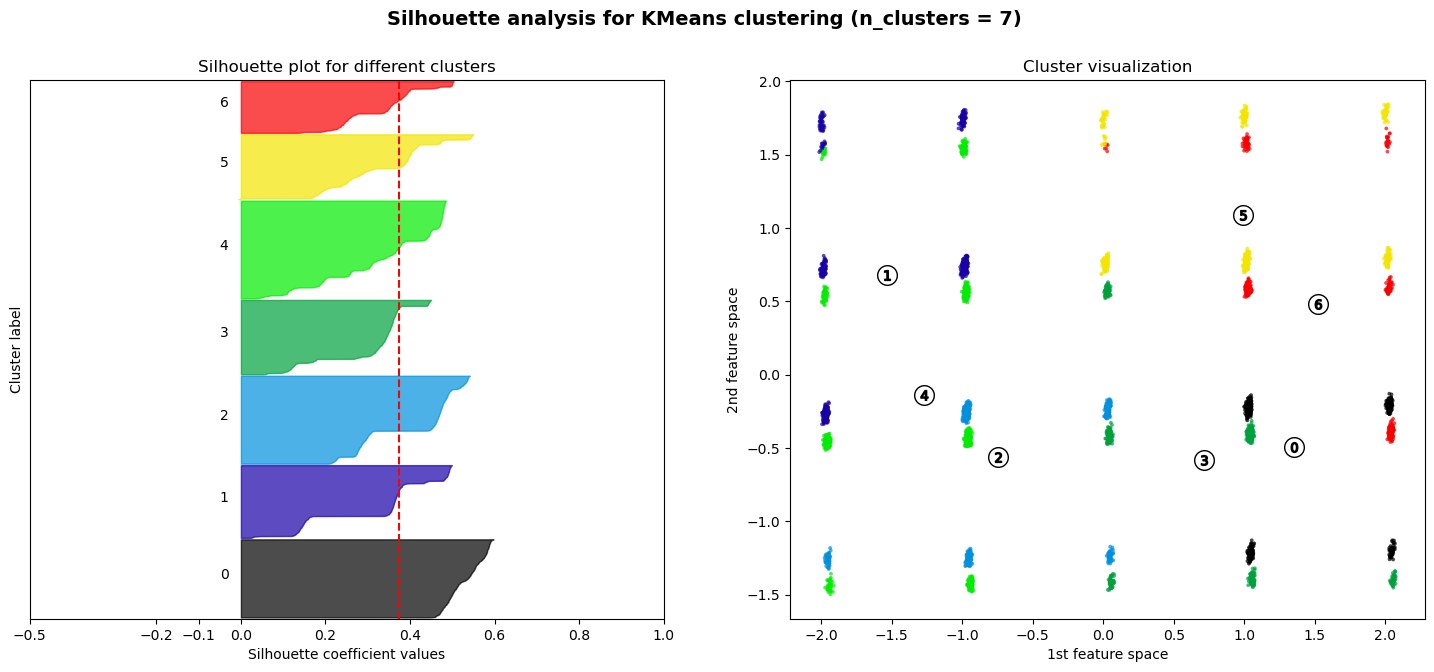

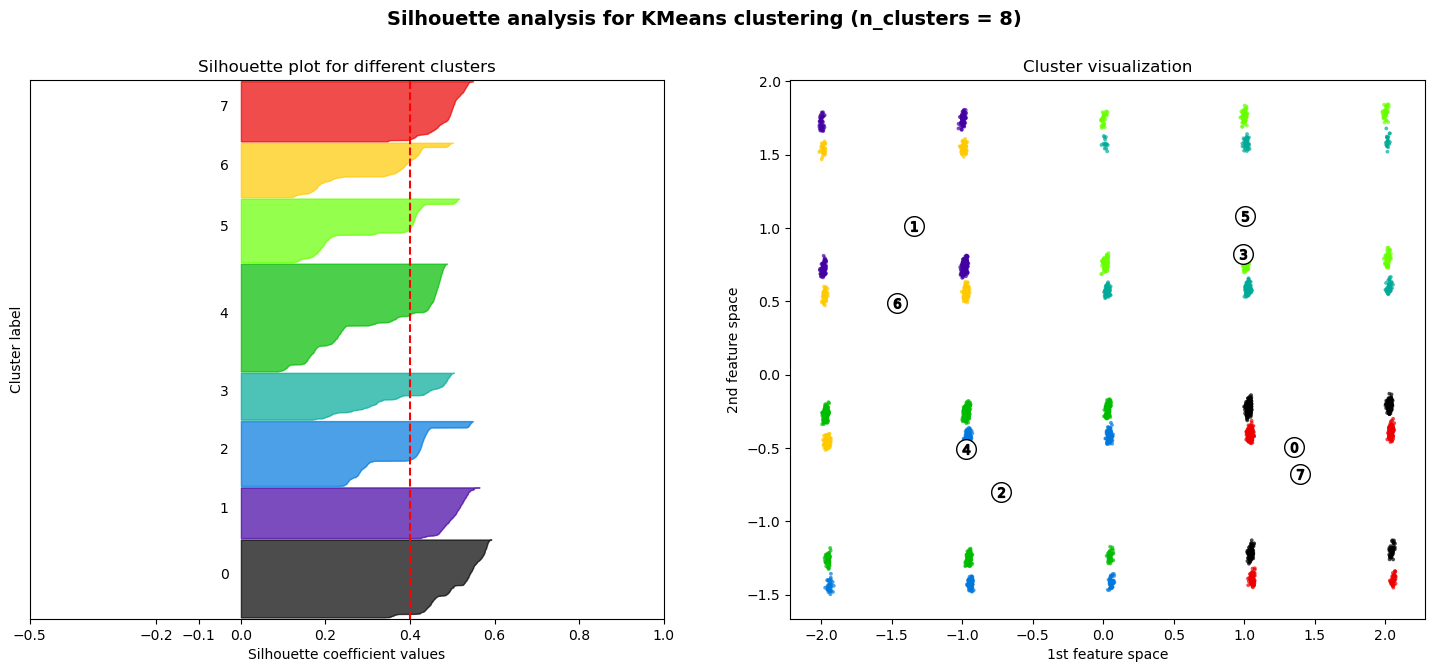

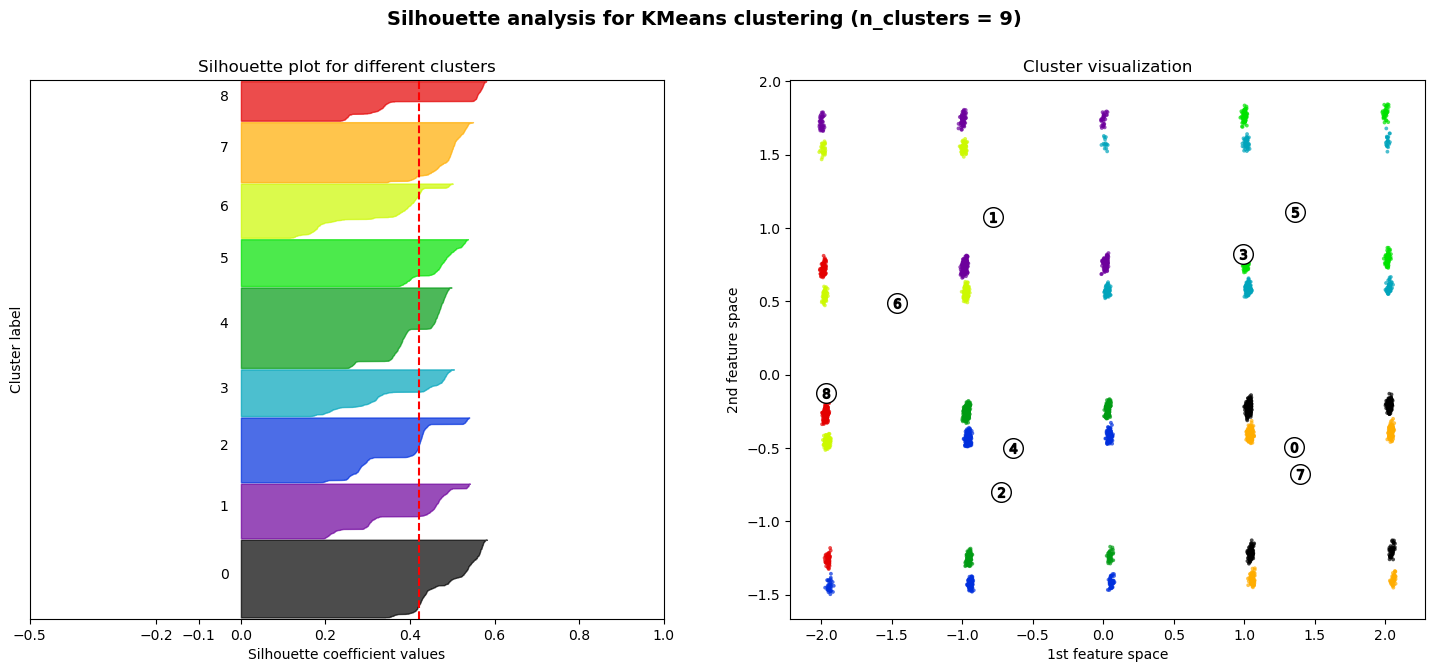

In [43]:
# Loop through each number of clusters (K) to evaluate clustering performance
for n_clusters in K:
    # Create a figure with two subplots (one for silhouette plot, one for cluster visualization)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Set the x and y limits for the silhouette plot
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    # Initialize KMeans with the current number of clusters and a fixed random seed
    clusterer = KMeans(n_clusters=n_clusters, random_state=SEEEDDDD)
    cluster_labels = clusterer.fit_predict(df_pca)

    # Calculate the average silhouette score for the current clustering
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_avg}")

    # Compute silhouette scores for each sample in the clusters
    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    # Initialize y_lower for placing silhouette bars on the plot
    y_lower = 10
    for i in range(n_clusters):
        # Get and sort silhouette values for the samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        # Get the size of the current cluster and determine where the bar ends
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Assign a color to the cluster based on its index
        color = cm.nipy_spectral(float(i) / n_clusters)

        # Create a filled region for each cluster's silhouette scores
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper), 
            0, 
            ith_cluster_silhouette_values, 
            facecolor=color, 
            edgecolor=color, 
            alpha=0.7
        )

        # Label the clusters in the silhouette plot
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Update y_lower for the next cluster's silhouette plot
        y_lower = y_upper + 10

    # Set titles and labels for the silhouette plot
    ax1.set_title("Silhouette plot for different clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Add a vertical line showing the average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Remove y-axis ticks
    ax1.set_xticks([-0.5, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Plot the clusters in the 2nd subplot
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    pca_comp = PCA(n_components=2)
    df_pca_2 = pca_comp.fit_transform(df_encoded)

    # Scatter plot of the 2D PCA components with cluster colors
    ax2.scatter(
        df_pca_2[:, 0], df_pca_2[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Plot the centers of the clusters as white circles
    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0], 
        centers[:, 1], 
        marker="o", 
        c="white", 
        alpha=1, 
        s=200, 
        edgecolor="k"
    )

    # Annotate the centers with their cluster index
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    # Set titles and labels for the second plot
    ax2.set_title("Cluster visualization")
    ax2.set_xlabel("1st feature space")
    ax2.set_ylabel("2nd feature space")

    # Add a main title for the whole figure
    plt.suptitle(
        f"Silhouette analysis for KMeans clustering (n_clusters = {n_clusters})", 
        fontsize=14, 
        fontweight="bold"
    )

# Show the final figure with both subplots
plt.show()

KMeans with 3 clusters

1. Silhouette Plot (Left Chart):
    - This chart provides insight into how well-separated the clusters are by visualizing the silhouette coefficient for each point.
    - Silhouette Coefficient: A measure of how similar each point is to its own cluster compared to other clusters. Values range from -1 to 1, with values closer to 1 indicating well-separated clusters, and values closer to -1 suggesting that the point may have been assigned to the wrong cluster.
    - Cluster 2 (highlighted in yellow) has a noticeably low silhouette coefficient, indicating that points in this cluster are not as well separated from the other clusters
    - Clusters 0 (black) and 1 (blue) show relatively better separation, with higher silhouette scores
    - The vertical red line shows the average silhouette score for all points in the dataset. Points to the left of the line are poorly clustered, while points to the right are better clustered

2. Cluster Visualization (Right Chart):
    - This chart plots the data points in a 2D space (the first and second principal components from PCA).
    - Clusters: Each color represents a different cluster (blue for Cluster 1, yellow for Cluster 2, black for Cluster 0). 
    - The plot shows that Cluster 0 and Cluster 1 are relatively well-separated in the feature space, whereas Cluster 2 is more spread out, potentially indicating that it is less distinct compared to the other clusters
    - The points from Cluster 2 (yellow) are scattered closer to points from other clusters, which aligns with the silhouette plot's indication that the points in this cluster are less well-defined

In [50]:
# Initialize a KMeans model with 3 clusters
model = KMeans(n_clusters = 3, random_state = SEEEDDDD)
# Fit the KMeans model to the data and predict the cluster labels for each data point
pred = model.fit_predict(df_pca)

In [51]:
df_kmeans = df.copy()
df_kmeans['Cluster']=pred # Add a new column 'Cluster' to the DataFrame that stores the cluster assignments for each row
pred

array([0, 0, 0, ..., 1, 0, 1])

In [52]:
df_kmeans

,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases,Age,Cluster
0,1,Blouse,Clothing,53,Kentucky,2,Gray,Winter,3.1,1,Credit Card,Express,1,1,14,Venmo,3,56,0
1,1,Sweater,Clothing,64,Maine,2,Maroon,Winter,3.1,1,Bank Transfer,Express,1,1,2,Cash,3,20,0
2,1,Jeans,Clothing,73,Massachusetts,0,Maroon,Spring,3.1,1,Cash,Free Shipping,1,1,23,Credit Card,4,51,0
3,1,Sandals,Footwear,90,Rhode Island,1,Maroon,Spring,3.5,1,PayPal,Next Day Air,1,1,49,PayPal,4,22,0
4,1,Blouse,Clothing,49,Oregon,1,Turquoise,Spring,2.7,1,Cash,Free Shipping,1,1,31,PayPal,0,46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,0,Hoodie,Clothing,28,Virginia,2,Turquoise,Summer,4.2,0,Cash,2-Day Shipping,0,0,32,Venmo,4,41,0
3896,0,Backpack,Accessories,49,Iowa,2,White,Spring,4.5,0,PayPal,Store Pickup,0,0,41,Bank Transfer,3,53,0
3897,0,Belt,Accessories,33,New Jersey,2,Green,Spring,2.9,0,Credit Card,Standard,0,0,24,Venmo,1,47,1
3898,0,Shoes,Footwear,77,Minnesota,0,Brown,Summer,3.8,0,PayPal,Express,0,0,24,Venmo,4,45,0


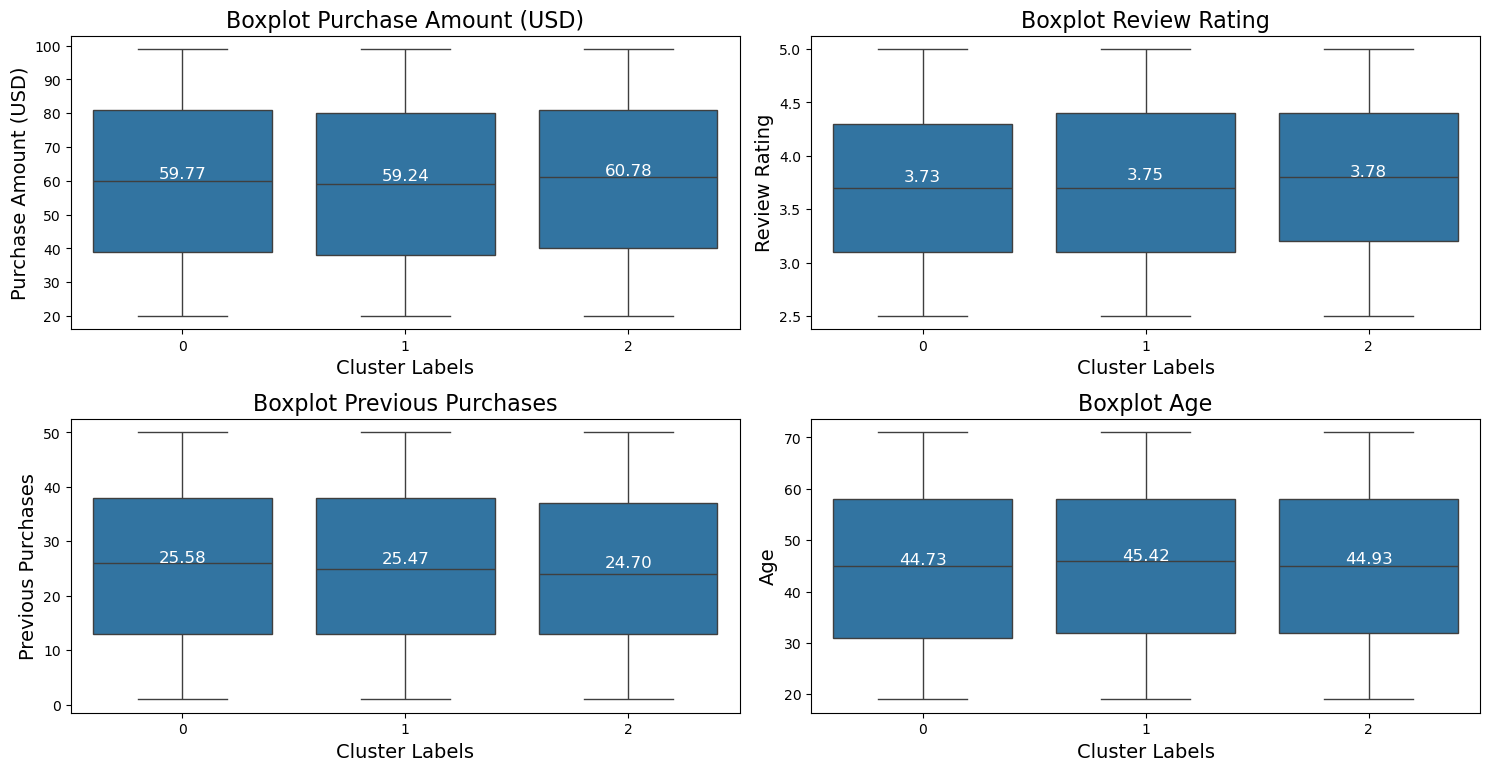

In [53]:
plt.figure(figsize=(15, 15))

# Loop over each feature in num_cols and create a boxplot for each
for i, fitur in enumerate(num_cols, 1):
    # Create a subplot for each feature
    plt.subplot(len(num_cols), 2, i)
    
    # Create a boxplot for the feature grouped by the 'Cluster' label, excluding outliers
    sns.boxplot(x='Cluster', y=fitur, data=df_kmeans, showfliers=False)
    
    # Set labels and title for each subplot
    plt.xlabel('Cluster Labels', fontsize=14)
    plt.ylabel(fitur, fontsize=14)
    plt.title(f'Boxplot {fitur}', fontsize=16)
    
    # Add the mean value for each cluster to the boxplot
    means = df_kmeans.groupby('Cluster')[fitur].mean().values
    for j, mean in enumerate(means):
        # Display the mean values on top of the boxplot boxes
        plt.text(j, mean, f'{mean:.2f}', ha='center', va='bottom', color='white', fontsize=12)

plt.tight_layout()
plt.show()

1. Purchase Amount (USD):
   - Cluster 0 has a median purchase amount of approximately 59.77 USD
   - Cluster 1 has a median purchase amount of about 59.24 USD
   - Cluster 2 has a median purchase amount of 60.78 USD
   - All clusters have similar median purchase amounts, showing that there isn't a significant difference between them

2. Review Rating:
   - Cluster 0 has a median review rating of 3.73
   - Cluster 1 has a median review rating of 3.75
   - Cluster 2 has a median review rating of 3.78
   - Review ratings are quite similar across clusters, with Cluster 2 having a slightly higher rating

3. Previous Purchases:
   - Cluster 0 has a median of 25.58 previous purchases
   - Cluster 1 has a median of 25.47 previous purchases
   - Cluster 2 has a median of 24.70 previous purchases
   - There is very little variation in the number of previous purchases between clusters

4. Age:
   - Cluster 0 has a median age of 44.73 years
   - Cluster 1 has a median age of 45.42 years
   - Cluster 2 has a median age of 44.93 years
   - The age distribution is very similar across the clusters, with no significant age differences

Summary of Characteristics:
- Cluster 0: Customers with similar purchase amounts and ratings, and slightly more previous purchases
- Cluster 1: Customers with a very similar profile to Cluster 0 but with slightly lower ratings and fewer previous purchases
- Cluster 2: Customers with a profile that closely matches Cluster 0, with slightly higher ratings and fewer previous purchases

C:\Users\User\AppData\Local\Temp\ipykernel_9824\3352588834.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
C:\Users\User\AppData\Local\Temp\ipykernel_9824\3352588834.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
C:\Users\User\AppData\Local\Temp\ipykernel_9824\3352588834.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
C:\Users\User\AppData\Local\Temp\ipykernel_9824\3352588834.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

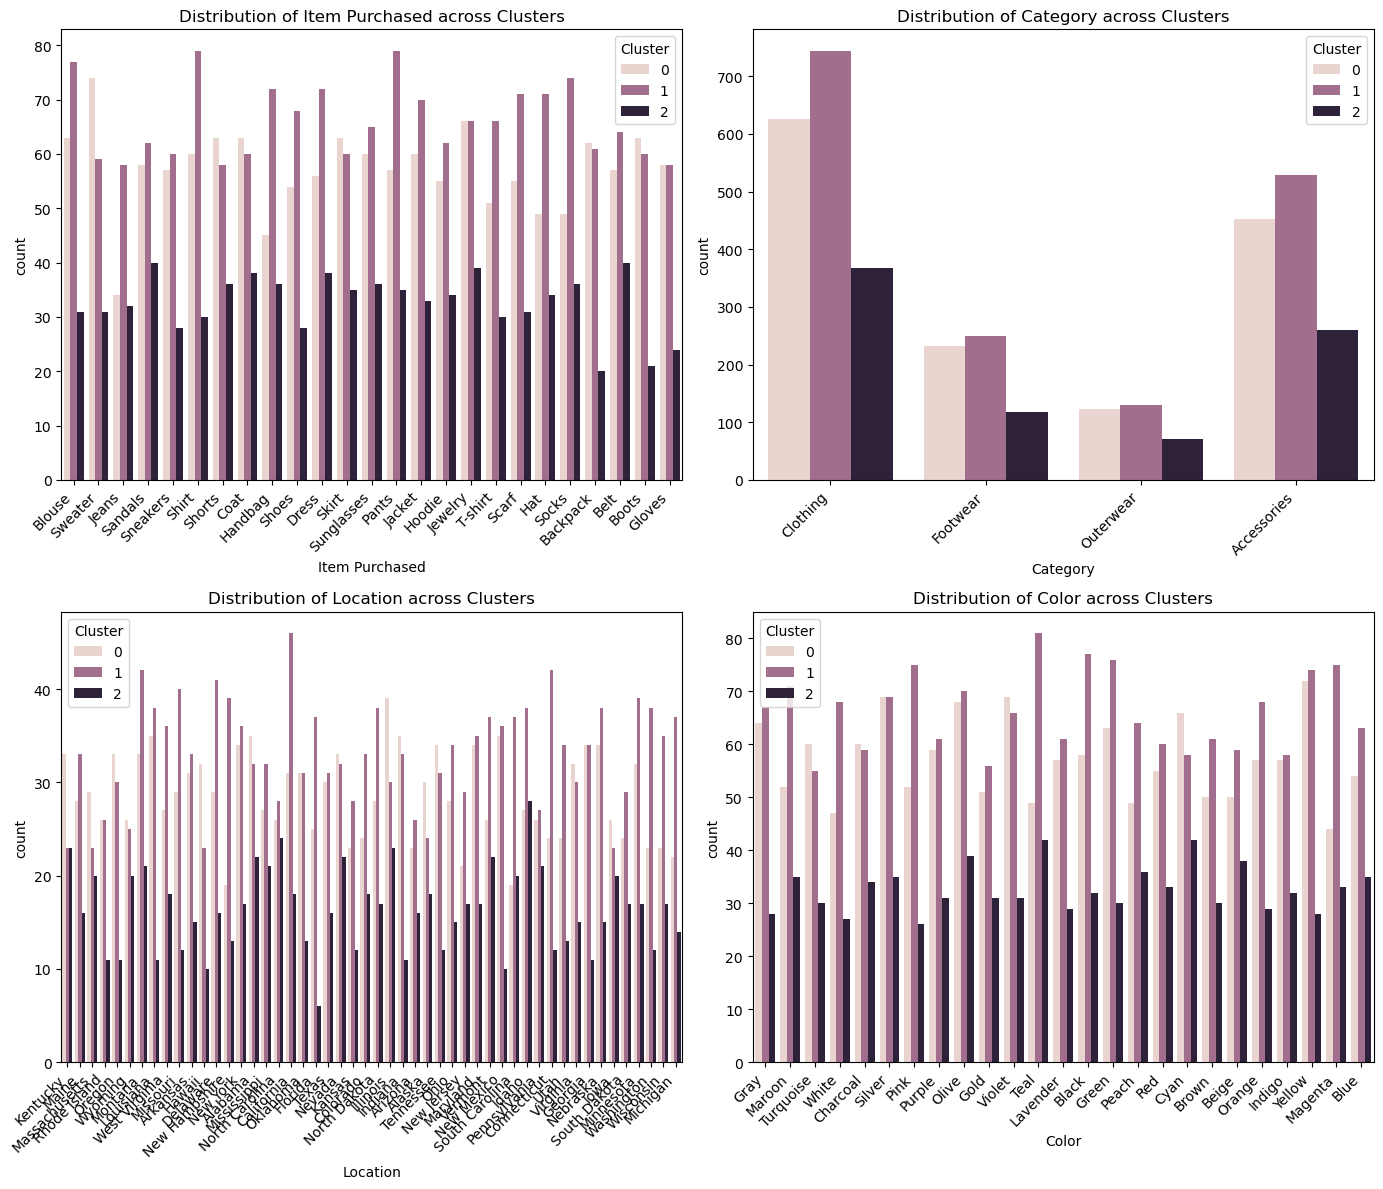

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots for categorical variable visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# List of categorical columns to plot
categorical_columns = ['Item Purchased', 'Category', 'Location', 'Color']

# Loop through the categorical columns and plot their distributions across clusters
for i, col in enumerate(categorical_columns):
    ax = axes[i//2, i%2]  # Determine subplot position
    sns.countplot(data=df_kmeans, x=col, hue='Cluster', ax=ax)
    ax.set_title(f'Distribution of {col} across Clusters')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [62]:
df_kmeans.groupby('Cluster').agg(
    {
        # For numerical columns, calculate the median
        'Purchase Amount (USD)': 'median',
        'Review Rating': 'median',
        'Previous Purchases': 'median',
        'Age': 'median',
        
        # For categorical columns, calculate the mode (most frequent category)
        **{col: lambda x: x.mode()[0] for col in cat_cols}
    }).reset_index()

,Cluster,Purchase Amount (USD),Review Rating,Previous Purchases,Age,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Preferred Payment Method,Frequency of Purchases
0,0,60.0,3.7,26.0,45.0,1,Sweater,Clothing,Illinois,1,Yellow,Spring,0,Credit Card,Standard,0,0,Cash,3
1,1,59.0,3.7,25.0,46.0,1,Pants,Clothing,California,1,Teal,Summer,0,Cash,Free Shipping,0,0,PayPal,1
2,2,61.0,3.8,24.0,45.0,1,Belt,Clothing,Idaho,0,Cyan,Spring,0,Credit Card,Store Pickup,0,0,Cash,2


### C. Characteristics of Each Customer Cluster

##### Cluster 0:
- Purchase Amount (USD): Median purchase amount is 60.0 USD, which is the most common value in this cluster.
- Review Rating: The majority of the customers have a review rating of 3.7.
- Previous Purchases: Most customers in this cluster have made 26 previous purchases (median).
- Age: Median age of customers is 45 years.
- Key Characteristics:
  - Most common product purchased: Sweaters.
  - Most common location: Illinois.
  - Size preference: Medium (M).
  - Most frequent color: Yellow.
  - Season preference: Spring.
  - Most common payment method: Credit Card.
  - Most common shipping type: Standard.
  - Frequency of Purchases: Every 3 months.

##### Cluster 1:
- Purchase Amount (USD): Median purchase amount is 59.0 USD.
- Review Rating: Median review rating is 3.7.
- Previous Purchases: The majority have 25 previous purchases.
- Age: Median age of customers is 46 years.
- Key Characteristics:
  - Most common product purchased: Pants.
  - Most common location: California.
  - Size preference: Medium (M).
  - Most frequent color: Teal.
  - Season preference: Summer.
  - Most common payment method: Cash.
  - Most common shipping type: Free Shipping.
  - Frequency of Purchases: Quarterly.

##### Cluster 2:
- Purchase Amount (USD): Median purchase amount is 61.0 USD.
- Review Rating: Median review rating is 3.8.
- Previous Purchases: Median previous purchases are 24.
- Age: Median age of customers is 45 years.
- Key Characteristics:
  - Most common product purchased: Belt.
  - Most common location: Idaho.
  - Size preference: Small (S).
  - Most frequent color: Cyan.
  - Season preference: Spring.
  - Most common payment method: Credit Card.
  - Most common shipping type: Store Pickup.
  - Frequency of Purchases: Bi-Weekly.

Trends:
- Purchase Amount: Most clusters show similar spending behavior around 59-61 USD
- Review Rating: Most ratings are clustered around 37-38 for all clusters, indicating generally positive feedback
- Product Preferences: Different clusters have distinct product preferences (Sweaters, Pants, Belts)
- Geographic Differences: Different locations like Illinois, California, and Idaho seem to play a role in the cluster differentiation
- Shipping and Payment Preferences: Each cluster has unique preferences for shipping types and payment methods (eg, Credit Card for Cluster 0 and Cash for Cluster 1)
- Frequency of Purchases: Cluster 0 tends to purchase every 3 months, Cluster 1 quarterly, and Cluster 2 bi-weekly, indicating differing purchase cycles

### Conclusion

Cluster 0:
Cluster 0 customers are primarily from Illinois, purchase Sweaters, and prefer Standard Shipping. They use Credit Card for payments and make purchases every 3 months. Their average purchase amount is around 60.0 USD, and their median age is 45 years.

Cluster 1:
Cluster 1 customers are mostly from California, buy Pants, and prefer Free Shipping. They use Cash for payments and purchase quarterly. Their average purchase amount is slightly lower (59.0 USD), with a median age of 46 years.

Cluster 2:
Cluster 2 customers are primarily located in Idaho, purchase Belts, and choose Store Pickup for shipping. They use Credit Card for payments and buy bi-weekly. Their average purchase amount is similar to Cluster 0 (61.0 USD), and they have a median age of 45 years. They purchase more frequently than the other clusters.